In [1]:
from models.fullvae_hist_glm import FullVAE_Hist_GLM, NN_Encoder

import numpy as np
import torch
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"

E_neural_file = "Espikes_neural.npy"
I_neural_file = "Ispikes_neural.npy"
V_file = "V_diff.npy"
C_syn_e_file = "handsub6_C_syn_e.npy"
C_syn_i_file = "handsub6_C_syn_i.npy"
C_den_file = "handsub6_C_den.npy"

E_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
C_syn_e = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_e_file)
C_syn_i = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_i_file)
C_den = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_den_file)

E_neural = torch.from_numpy(E_neural)
I_neural = torch.from_numpy(I_neural)
C_syn_e = torch.from_numpy(C_syn_e)
C_syn_i = torch.from_numpy(C_syn_i)
V = torch.from_numpy(V)
C_den = torch.from_numpy(C_den)
sub_no = C_den.shape[0]

In [3]:
T_train = 60 * 1000 * 5
T_test = 10 * 1000 * 5
T_no = 50
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_size = 100000
iter_no = 20000
epoch_no = 15
layer_no = 3

In [4]:
V_train = V[:T_train].to(device).float()
V_test = V[T_train:T_train + T_test].to(device).float()
test_E_neural = E_neural[T_train:T_train+T_test].float().to(device)
test_I_neural = I_neural[T_train:T_train+T_test].float().to(device)
train_E_neural = E_neural[:T_train].float().to(device)
train_I_neural = I_neural[:T_train].float().to(device)
C_syn_e = C_syn_e.float().to(device)
C_syn_i = C_syn_i.float().to(device)
C_den = C_den.float().to(device)

batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train - batch_size))
for i in range(epoch_no):
    part_idx = np.arange(T_train - batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [5]:
decoder = FullVAE_Hist_GLM(C_den, C_syn_e, C_syn_i, T_no, device)
encoder = NN_Encoder(C_syn_e, C_syn_i, T_no, layer_no, device)

enc_optimizer = torch.optim.Adam(encoder.parameters(), lr = 0.0001)
dec_optimizer = torch.optim.Adam(decoder.parameters(), lr = 0.001)

encoder.to(device).float()
decoder.to(device).float()
print(sum(p.numel() for p in encoder.parameters() if p.requires_grad))
print(sum(p.numel() for p in decoder.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="mean")

11772
475


In [ ]:
Z_prior = torch.ones(batch_size, sub_no).to(device) * 0.001
temp_list = [0.5,0.4,0.3,0.2,0.1,0.09,0.08,0.07,0.06,0.05,0.04,0.03,0.02,0.01]
temp_count = 0

for i in tnrange(iter_no):
    encoder.train()
    decoder.train()
    enc_optimizer.zero_grad()
    dec_optimizer.zero_grad()
    
    #if (i%500==0) & (temp_count < 14):
        #temp = temp_list[temp_count]
        #temp_count += 1
        
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size]
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size]
    batch_V = V_train[batch_idx : batch_idx+batch_size]
    
    spk_enc, Z_enc = encoder(batch_V, batch_E_neural, batch_I_neural) 
    
    V_pred, Z_pred, out_filters = decoder.train_forward(batch_E_neural,
                                                         batch_I_neural,
                                                         spk_enc)
    
    
    prior_loss = bce_criterion(Z_enc , Z_prior)
    bern_loss = bce_criterion(Z_pred, spk_enc.detach())
    var_loss = torch.var(batch_V - V_pred)
    
    loss_var_exp = metrics.explained_variance_score(y_true=batch_V.cpu().detach().numpy(),
                                                      y_pred=V_pred.cpu().detach().numpy())
    
    smooth_loss = torch.mean((out_filters[:,1:] - out_filters[:,:-1]) ** 2)    
    
    loss = var_loss + bern_loss + prior_loss + 0*smooth_loss
    loss.backward()
    enc_optimizer.step()
    dec_optimizer.step()
    
    if i%500 == 499:
        encoder.eval()
        decoder.eval()
        test_V_pred, test_spk_pred, test_prob_pred, test_out_filters = decoder.test_forward(test_E_neural, test_I_neural)
        
        test_var_exp = metrics.explained_variance_score(y_true=V_test.cpu().detach().numpy(),
                                                      y_pred=test_V_pred.cpu().detach().numpy())
        #train_V_pred, train_spk_pred, train_prob_pred, train_out_filters = decoder.test_forward(batch_E_neural, batch_I_neural)
        
        #train_var_exp = metrics.explained_variance_score(y_true=batch_V.cpu().detach().numpy(),
                                                      #y_pred=train_V_pred.cpu().detach().numpy())
        
        print(i, test_var_exp, loss_var_exp)
        print(bern_loss.item(), prior_loss.item(), smooth_loss.item())

<ipython-input-6-f8e79b2bf932>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


499 -0.01740431785583496 0.36950331926345825
0.28049442172050476 0.05134693160653114 0.0031921761110424995
999 -1.9069201946258545 0.5645817518234253
0.13691896200180054 0.028126077726483345 0.004386577755212784
1499 -3.9442973136901855 0.6909785270690918
0.08925922960042953 0.017352590337395668 0.003934698179364204


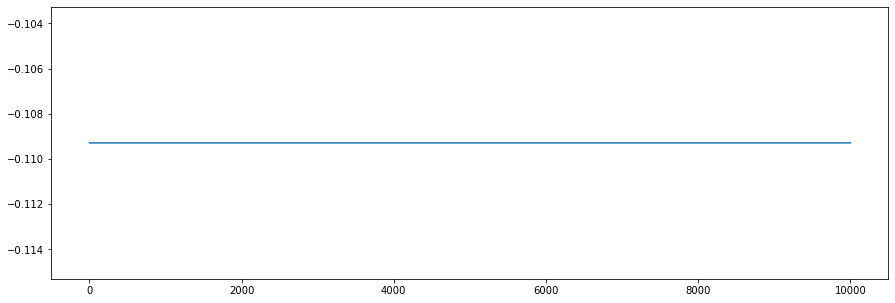

In [8]:
plt.figure(figsize=(15,5))
plt.plot(test_V_pred.cpu().detach().numpy()[15000:25000])
plt.plot(V_test.cpu().detach().numpy()[15000:25000])
#plt.ylim(0,0.1)

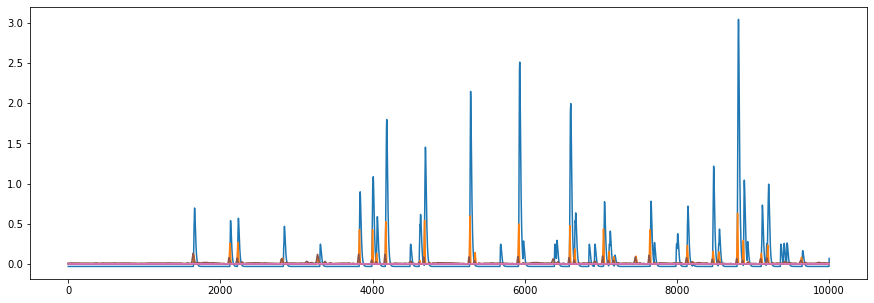

In [10]:
plt.figure(figsize=(15,5))
plt.plot(V_pred.cpu().detach().numpy()[5000:15000])
plt.plot(Z_enc.cpu().detach().numpy()[5000:15000])

torch.Size([24, 150])


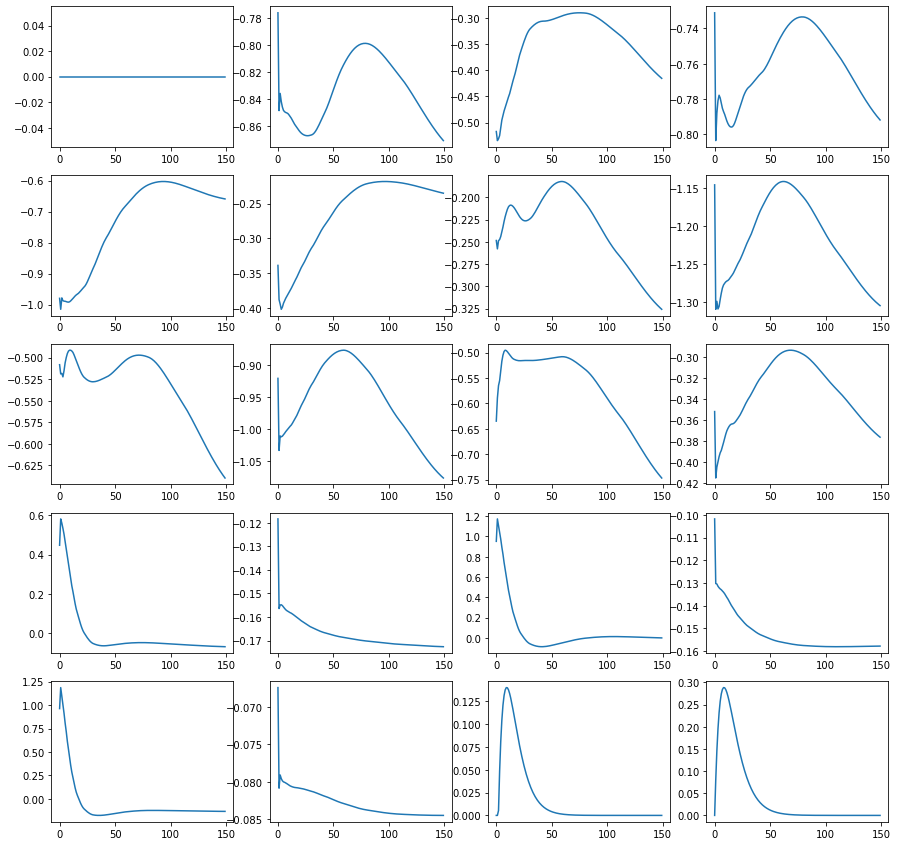

In [9]:
print(out_filters.shape)
plot_no = 20
fig, axs = plt.subplots(nrows=5, ncols=4, figsize = (15,15))
for row in range(5):
    for col in range(4):
        axs[row,col].plot(out_filters[row*4+col].cpu().detach().numpy())
        